<a href="https://colab.research.google.com/github/andBabaev/awesomem-action-recognition/blob/master/moment_in_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tqdm --upgrade

     |████████████████████████████████| 71kB 5.1MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [2]:
from keras import backend as K
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Model, Sequential, load_model
from keras.layers import Dense,GlobalAveragePooling2D, TimeDistributed, LSTM, Input, Flatten, Conv3D, MaxPool3D, GlobalAveragePooling3D
from keras.layers import Conv2D, Reshape, Permute, Concatenate, BatchNormalization, Lambda
from keras.regularizers import l2
from keras.applications import Xception, MobileNetV2
from keras.utils import Sequence, to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.utils import class_weight
import numpy as np
import cv2
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import multiprocessing as mp
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
import os

Using TensorFlow backend.


In [0]:
root_path_models = '/content/drive/My Drive/roonyx_models'

# Split data

In [0]:
#!wget http://data.csail.mit.edu/soundnet/actions3/split1/Moments_in_Time_Mini.zip
#!cp 'Moments_in_Time_Mini.zip' 'drive/My Drive/'

In [0]:
# !cp 'drive/My Drive/Moments_in_Time_Mini.zip' './'
# !unzip -qq 'Moments_in_Time_Mini.zip'

In [0]:
!mkdir './roonyx_data/'
!cp 'drive/My Drive/roonyx_data/training1.rar' './'
!cp 'drive/My Drive/roonyx_data/validation1.rar' './'
!cp 'drive/My Drive/roonyx_data/trainingSet.csv' './roonyx_data/'
!cp 'drive/My Drive/roonyx_data/validationSet.csv' './roonyx_data/'

!unrar -idq x '/content/training1.rar'  '/content/roonyx_data/training/'
!unrar -idq x '/content/validation1.rar'  '/content/roonyx_data/validation/'
!rm '/content/training1.rar'
!rm '/content/validation1.rar'

In [14]:
target_classes = ['smoking', 'punching', 'bicycling', 'typing', 'discussing', 
                  'dancing', 'telephoning', 'shooting', 'exercising', 'drawing']
# target_classes = ['bicycling', 'cooking', 'dancing', 'drawing', 'drinking',
#                   'eating', 'crying', 'walking', 'exercising', 'jumping']
n_classes = len(target_classes)
print(sorted(target_classes))

root_path = 'roonyx_data/'
#root_path = 'Moments_in_Time_Mini/'

['bicycling', 'dancing', 'discussing', 'drawing', 'exercising', 'punching', 'shooting', 'smoking', 'telephoning', 'typing']


In [0]:

train_df = pd.read_csv(root_path+"trainingSet.csv", header=None, 
                 names=['filename', 'label', 'good', 'bad'] )
test_df = pd.read_csv(root_path+"validationSet.csv", header=None, 
                 names=['filename', 'label', 'good', 'bad'] )
train_df = train_df[train_df.label.isin(target_classes)]
test_df = test_df[test_df.label.isin(target_classes)]

In [0]:
train_df['%good'] = train_df.good / (train_df.bad + train_df.good)
train_df = train_df[train_df['%good'] > 0.7]
# train_df = train_df[train_df['bad'] == 0]
# test_df = test_df[test_df['bad'] == 0]

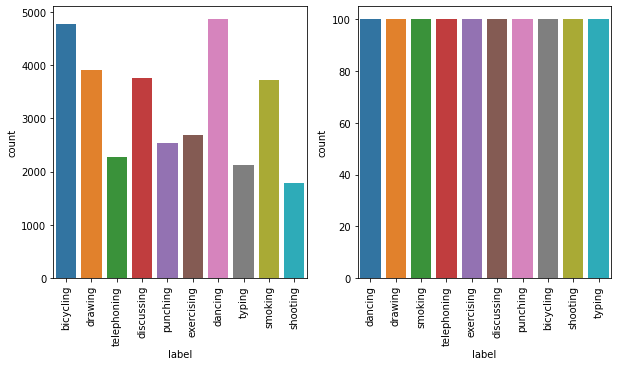

In [17]:
import seaborn as sns
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.xticks(rotation=90)
sns.countplot(train_df.label)
plt.subplot(1,2,2)
plt.xticks(rotation=90)
sns.countplot(test_df.label);

In [18]:
train_df.label.value_counts()

dancing        4858
bicycling      4765
drawing        3911
discussing     3753
smoking        3728
exercising     2679
punching       2535
telephoning    2271
typing         2120
shooting       1793
Name: label, dtype: int64

In [0]:
train_df['filename'] = root_path+'training/' + train_df.filename
test_df['filename'] = root_path+'validation/' + test_df.filename

train_df['label'] = train_df.label.map({class_: ind for ind, class_ in enumerate(target_classes)})
test_df['label'] = test_df.label.map({class_: ind for ind, class_ in enumerate(target_classes)})
# classes = train_df['label'].unique()
# train_df['label'] = train_df.label.map({class_: ind for ind, class_ in enumerate(classes)})
# test_df['label'] = test_df.label.map({class_: ind for ind, class_ in enumerate(classes)})

dataset_IDs = {'train': train_df.filename.values,
               'test': test_df.filename.values,
              }
labels = {}
for filename, label in train_df[['filename', 'label']].values:
    labels[filename] = label
for filename, label in test_df[['filename', 'label']].values:
    labels[filename] = label

## Frame extractor

In [0]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
def f(ID):
    path_to_video = ID.replace('?s=', '_s=')
    path_to_image = path_to_video.rsplit('.', 1)[0] +'_%s.png'

    cap = cv2.VideoCapture(path_to_video)
    
    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_no = (np.random.randint(0, np.min([15, (frame_num - len_seq*(frame_step+1))])))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)

    for j in range(len_seq):
        
        ret, frame = cap.read()
        #frame = cv2.resize(frame, image_shape, interpolation=cv2.INTER_AREA)
        temp_path = path_to_image % (j)
        cv2.imwrite(temp_path, frame)

        #dataset_IDs_images[set_type].append(temp_path)
        #labels_images[temp_path] = labels[ID]

        for _ in range(frame_step):
            _, _ = cap.read()

    cap.release()
    return True

In [0]:
p=mp.Pool(8)
for set_type, set_paths in dataset_IDs.items():
    for i in tqdm(p.imap(f,set_paths), total=len(set_paths), position=0):
        pass

# CNN+LSTM

## Data generator

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, 
                 batch_size=32, image_shape=(299,299), n_channels=3, len_seq = 30,
                 frame_step=1,
                 n_classes=10, shuffle=True, resizing=False, interpolation=cv2.INTER_AREA):
        'Initialization'
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resizing = resizing
        self.len_seq = len_seq
        self.frame_step = frame_step
        self.interpolation = interpolation
        self.on_epoch_end()
        print('Size of generator:', len(self.list_IDs))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # def __data_generation(self, list_IDs_temp):
    #     'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    #     # Initialization
    #     X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
    #     y = np.empty((self.batch_size), dtype=int)

    #     # Generate data
    #     for i, ID in enumerate(list_IDs_temp):
    #         # Store sample
            
    #         cap = cv2.VideoCapture(ID.replace('?s=', '_s='))
            
    #         frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    #         frame_no = (np.random.randint(0, np.min([15, (frame_num - self.len_seq*(self.frame_step+1))])))
    #         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    #         for j in range(self.len_seq):
                
    #             ret, frame = cap.read()
    #             if ret:
    #                 X[i, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
    #                                          self.image_shape, 
    #                                          interpolation=self.interpolation)
    #             for _ in range(self.frame_step):
    #                 _, _ = cap.read()

    #         cap.release()
    #         # Store class
    #         X[i] = preprocess_input(X[i])
    #         y[i] = self.labels[ID]
    #     #X = np.transpose(X, (0,2,3,1,4))
    #     return X, to_categorical(y, num_classes=self.n_classes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        X_flow = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path_to_video = ID.replace('?s=', '_s=')
            path_to_image = path_to_video.rsplit('.', 1)[0] +'_%s.png'

            x_indent = np.random.randint(0, 256-self.image_shape[1])
            y_indent = np.random.randint(0, 256-self.image_shape[0])
            
            flip_flag = np.random.choice(['no_flip', 'horiz_flip'], 1)[0]

            for j in range(self.len_seq):
                # frame = cv2.imread(path_to_image % (j))
                # X[i, j,] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = image.load_img(path_to_image % (j))
                x = image.img_to_array(img)[y_indent:self.image_shape[0]+y_indent,
                                            x_indent:self.image_shape[1]+x_indent]
                
                if flip_flag == 'horiz_flip':
                    x = np.fliplr(x)

                X[i, j,] = x
            X[i] = preprocess_input(X[i])
            y[i] = self.labels[ID]
        #X = np.transpose(X, (0,2,3,1,4))
        #return X, to_categorical(y, num_classes=self.n_classes)
        return X, to_categorical(y, num_classes=self.n_classes)

    



## Model

In [23]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
n_channels = 3
n_classes = train_df.label.unique().shape[0]
params = {'image_shape': image_shape,
          'batch_size': 16,
          'n_classes': n_classes,
          'len_seq': len_seq,
          'frame_step': frame_step,
          'n_channels': n_channels,
          'shuffle': True}

# Generators
training_generator = DataGenerator(dataset_IDs['train'], labels, **params)
validation_generator = DataGenerator(dataset_IDs['test'], labels, **params)

Size of generator: 32413
Size of generator: 1000


In [0]:
path_to_save_model = os.path.join(root_path_models, 'mobnet_2xlstm128_new_classes')
if not os.path.exists(path_to_save_model):
    os.mkdir(path_to_save_model)

In [25]:
seqShape = (len_seq, *image_shape,n_channels)
inputs = Input(seqShape)

base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(*image_shape,n_channels))
outputs = TimeDistributed(base_model)(inputs)

x = TimeDistributed(GlobalAveragePooling2D())(outputs)
x = LSTM(128, dropout=0.5, return_sequences=True)(x)
x = LSTM(128)(x)
preds = Dense(training_generator.n_classes, activation='softmax')(x)

model = Model(inputs,preds)
model.summary()

9412608/9406464 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10, 224, 224, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 7, 7, 1280)    2257984   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 1280)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 128)           721408    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 3,112,266
Trainable params: 3,078,154
Non-traina

In [0]:
#base_model.summary()

In [27]:
for i, layer in enumerate(base_model.layers):
    if '15' in layer.name:
        print(i, layer.name)

135 block_15_expand
136 block_15_expand_BN
137 block_15_expand_relu
138 block_15_depthwise
139 block_15_depthwise_BN
140 block_15_depthwise_relu
141 block_15_project
142 block_15_project_BN
143 block_15_add


In [0]:
for layer in base_model.layers:
        layer.trainable = False

top_weights_path = '/content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/only_classifier-20-0.56.h5'
model.load_weights(top_weights_path)

model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

In [0]:
top_weights_path = path_to_save_model + '/only_classifier-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    #EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
]

In [0]:
w = class_weight.compute_class_weight('balanced',  np.unique(train_df.label.values),train_df.label.values)

In [31]:
# Train model on dataset
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=30,
                              callbacks=callbacks_list,
                              class_weight=w)

Epoch 1/30
2025/2025 [==============================] - 1562s 771ms/step - loss: 0.9743 - accuracy: 0.6731 - val_loss: 1.8854 - val_accuracy: 0.5544

Epoch 00001: val_accuracy improved from -inf to 0.55444, saving model to /content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/only_classifier-01-0.55.h5
Epoch 2/30
2025/2025 [==============================] - 1569s 775ms/step - loss: 0.9644 - accuracy: 0.6757 - val_loss: 1.5317 - val_accuracy: 0.5544

Epoch 00002: val_accuracy did not improve from 0.55444
Epoch 3/30
2025/2025 [==============================] - 1541s 761ms/step - loss: 0.9688 - accuracy: 0.6754 - val_loss: 1.4495 - val_accuracy: 0.5383

Epoch 00003: val_accuracy did not improve from 0.55444
Epoch 4/30
2025/2025 [==============================] - 1525s 753ms/step - loss: 0.9647 - accuracy: 0.6768 - val_loss: 2.1193 - val_accuracy: 0.5514

Epoch 00004: val_accuracy did not improve from 0.55444
Epoch 5/30
2025/2025 [==============================] - 1540s 760ms/

KeyboardInterrupt: ignored

In [0]:
top_weights_path = '/content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/only_classifier-09-0.57.h5'
model.load_weights(top_weights_path)

In [0]:
# for layer in base_model.layers[:135]:
#         layer.trainable = False
# for layer in base_model.layers[135:]:
#     layer.trainable = True
for layer in base_model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [0]:
final_weights_path = path_to_save_model + '/full_model_weights-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    ModelCheckpoint(final_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, verbose=0)
]

In [35]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
n_channels = 3
params = {'image_shape': image_shape,
          'batch_size': 8,
          'n_classes': n_classes,
          'len_seq': len_seq,
          'frame_step': frame_step,
          'n_channels': n_channels,
          'shuffle': True}

# Generators
training_generator = DataGenerator(dataset_IDs['train'], labels, **params)
validation_generator = DataGenerator(dataset_IDs['test'], labels, **params)

Size of generator: 32413
Size of generator: 1000


In [0]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=30,
                              callbacks=callbacks_list,
                             class_weight=w)

Epoch 1/30
4051/4051 [==============================] - 2783s 687ms/step - loss: 1.0221 - accuracy: 0.6640 - val_loss: 1.6460 - val_accuracy: 0.5620

Epoch 00001: val_accuracy improved from -inf to 0.56200, saving model to /content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/full_model_weights-01-0.56.h5
Epoch 2/30
4051/4051 [==============================] - 2784s 687ms/step - loss: 0.9016 - accuracy: 0.7071 - val_loss: 1.5119 - val_accuracy: 0.5760

Epoch 00002: val_accuracy improved from 0.56200 to 0.57600, saving model to /content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/full_model_weights-02-0.58.h5
Epoch 3/30
4051/4051 [==============================] - 2782s 687ms/step - loss: 0.8385 - accuracy: 0.7271 - val_loss: 1.6926 - val_accuracy: 0.5810

Epoch 00003: val_accuracy improved from 0.57600 to 0.58100, saving model to /content/drive/My Drive/roonyx_models/mobnet_2xlstm128_new_classes/full_model_weights-03-0.58.h5
Epoch 4/30
1596/4051 [==========>.

In [0]:
model.save(root_path_models+'/Mobnet_overfitting')

# CNN+LSTM flow

## Data generator

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, 
                 batch_size=32, image_shape=(299,299), n_channels=3, len_seq = 30,
                 frame_step=1,
                 n_classes=10, shuffle=True, resizing=False, interpolation=cv2.INTER_AREA):
        'Initialization'
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resizing = resizing
        self.len_seq = len_seq
        self.frame_step = frame_step
        self.interpolation = interpolation
        self.on_epoch_end()
        print('Size of generator:', len(self.list_IDs))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    # def __data_generation(self, list_IDs_temp):
    #     'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    #     # Initialization
    #     X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
    #     y = np.empty((self.batch_size), dtype=int)

    #     # Generate data
    #     for i, ID in enumerate(list_IDs_temp):
    #         # Store sample
            
    #         cap = cv2.VideoCapture(ID.replace('?s=', '_s='))
            
    #         frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    #         frame_no = (np.random.randint(0, np.min([15, (frame_num - self.len_seq*(self.frame_step+1))])))
    #         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    #         for j in range(self.len_seq):
                
    #             ret, frame = cap.read()
    #             if ret:
    #                 X[i, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
    #                                         self.image_shape, 
    #                                         interpolation=self.interpolation)[:,:, np.newaxis]
    #                 #print(X[i, j,].max())
    #             for _ in range(self.frame_step):
    #                 _, _ = cap.read()

    #         cap.release()
    #         # Store class
    #         y[i] = self.labels[ID]
    #     #X = np.transpose(X, (0,2,3,1,4))
    #     #return X, to_categorical(y, num_classes=self.n_classes)
    #     return X/255., to_categorical(y, num_classes=self.n_classes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels), dtype=np.float32)
        X_flow = np.zeros((self.batch_size, self.len_seq, *self.image_shape, self.n_channels), dtype=np.float32)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path_to_video = ID.replace('?s=', '_s=')
            path_to_image = path_to_video.rsplit('.', 1)[0] +'_%s.png'
            
            for j in range(self.len_seq):
                # frame = cv2.imread(path_to_image % (j))
                # X[i, j,] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = image.load_img(path_to_image % (j), target_size=self.image_shape)
                x = image.img_to_array(img)
                X[i, j,] = x

                if j:
                    prvs = cv2.cvtColor(X[i,j-1],cv2.COLOR_BGR2GRAY)
                    hsv = np.zeros_like(X[i,j-1], dtype=np.float32)
                    hsv[...,1] = 255
                    next = cv2.cvtColor(X[i,j],cv2.COLOR_BGR2GRAY)
                    flow = cv2.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
                    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
                    hsv[...,0] = ang*180/np.pi/2
                    hsv[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
                    X_flow[i,j] = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)


            #X[i] = preprocess_input(X[i])
            y[i] = self.labels[ID]
        #X = np.transpose(X, (0,2,3,1,4))
        #return X, to_categorical(y, num_classes=self.n_classes)
        return [X/255.0, X_flow/255.], to_categorical(y, num_classes=self.n_classes)

    



## Model

In [0]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
n_channels = 3
params = {'image_shape': image_shape,
          'batch_size': 4,
          'n_classes': len(target_classes),
          'len_seq': len_seq,
          'frame_step': frame_step,
          'n_channels': n_channels,
          'shuffle': True}

# Generators
training_generator = DataGenerator(dataset_IDs['train'], labels, **params)
validation_generator = DataGenerator(dataset_IDs['test'], labels, **params)

Size of generator: 4500
Size of generator: 450


In [0]:
path_to_save_model = os.path.join(root_path_models, 'mobnet_2xlstm_flow')
if not os.path.exists(path_to_save_model):
    os.mkdir(path_to_save_model)

In [0]:
seqShape = (len_seq, *image_shape,n_channels)
inputs = Input(seqShape)
base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(*image_shape,n_channels))
outputs = TimeDistributed(base_model)(inputs)
x = TimeDistributed(GlobalAveragePooling2D())(outputs)

seqShape = (len_seq, *image_shape,n_channels)
inputs1 = Input(seqShape)
base_model1 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(*image_shape,n_channels))
outputs1 = TimeDistributed(base_model1)(inputs1)
x1 = TimeDistributed(GlobalAveragePooling2D())(outputs1)
x = Concatenate()([x, x1])
x = LSTM(256, return_sequences=True, dropout=0.5)(x)
x = LSTM(256, dropout=0.5)(x)
preds = Dense(len(target_classes), activation='softmax')(x)

model = Model([inputs, inputs1], preds)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 10, 224, 224, 0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 10, 224, 224, 0                                            
__________________________________________________________________________________________________
time_distributed_15 (TimeDistri (None, 10, 7, 7, 128 2257984     input_15[0][0]                   
__________________________________________________________________________________________________
time_distributed_17 (TimeDistri (None, 10, 7, 7, 128 2257984     input_17[0][0]                   
____________________________________________________________________________________________

In [0]:
# for layer in base_model.layers[:135]:
#         layer.trainable = False
# for layer in base_model.layers[135:]:
#     layer.trainable = True
# for layer in base_model1.layers[:135]:
#         layer.trainable = False
# for layer in base_model1.layers[135:]:
#     layer.trainable = True
for layer in base_model.layers:
        layer.trainable = False

model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

In [0]:
top_weights_path = path_to_save_model+'/only_classifier-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
]

In [0]:
# Train model on dataset
w = class_weight.compute_class_weight('balanced',  np.unique(train_df.label.values),train_df.label.values)

history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=30,
                              callbacks=callbacks_list,
                              class_weight=w)

In [0]:
model.load_weights('/content/drive/My Drive/roonyx_models/mobnet_2xlstm_flow/Mobilenet_2lst128-12-0.51.h5')

In [0]:
for layer in base_model.layers:
        layer.trainable = True
for layer in base_model1.layers:
        layer.trainable = False

model.compile(optimizer=Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model.summary()

In [0]:
top_weights_path = path_to_save_model+'/Mobilenet_2lst128-final-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
]

In [0]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=30,
                              callbacks=callbacks_list)

# YOWO

## Data generator

In [0]:
class DataGeneratorTwoStream(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, 
                 batch_size=32, image_shape=(299,299), n_channels=3, len_seq = 30,
                 frame_step=1,
                 n_classes=10, shuffle=True, resizing=False, interpolation=cv2.INTER_AREA):
        'Initialization'
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resizing = resizing
        self.len_seq = len_seq
        self.frame_step = frame_step
        self.interpolation = interpolation
        self.on_epoch_end()
        print('Size of generator:', len(self.list_IDs))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        X_flow = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path_to_video = ID.replace('?s=', '_s=')
            path_to_image = path_to_video.rsplit('.', 1)[0] +'_%s.png'

            x_indent = np.random.randint(0, 256-self.image_shape[1])
            y_indent = np.random.randint(0, 256-self.image_shape[0])
            
            flip_flag = np.random.choice(['no_flip', 'horiz_flip'], 1)[0]

            for j in range(self.len_seq):
                # frame = cv2.imread(path_to_image % (j))
                # X[i, j,] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = image.load_img(path_to_image % (j))
                x = image.img_to_array(img)[y_indent:self.image_shape[0]+y_indent,
                                            x_indent:self.image_shape[1]+x_indent]
                
                if flip_flag == 'horiz_flip':
                    x = np.fliplr(x)

                X[i, j,] = x
            X[i] = preprocess_input(X[i])
            y[i] = self.labels[ID]
        #X = np.transpose(X, (0,2,3,1,4))
        #return X, to_categorical(y, num_classes=self.n_classes)
        return [X, X[:,-1]], to_categorical(y, num_classes=self.n_classes)


## Model

In [0]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
n_channels = 3
params = {'image_shape': image_shape,
          'batch_size': 4,
          'n_classes': len(target_classes),
          'len_seq': len_seq,
          'frame_step': frame_step,
          'n_channels': n_channels,
          'shuffle': True}

# Generators
training_generator = DataGeneratorTwoStream(dataset_IDs['train'], labels, **params)
validation_generator = DataGeneratorTwoStream(dataset_IDs['test'], labels, **params)

Size of generator: 32663
Size of generator: 1000


In [0]:
path_to_save_model = os.path.join(root_path_models, 'mobnet_yowo_mit_mini')
if not os.path.exists(path_to_save_model):
    os.mkdir(path_to_save_model)

In [0]:
seqShape = (len_seq, *image_shape,n_channels)
inputs = Input(seqShape)
base_model = MobileNetV2(weights='imagenet',include_top=False, input_shape=(*image_shape,n_channels))
outputs = TimeDistributed(base_model)(inputs)
x = Permute((2, 3, 4, 1))(outputs)
x = Reshape((7,7,1280*len_seq))(x)
x = Conv2D(1280, (1,1), padding='same', activation='relu')(x)

inputs_1 = Input((*image_shape,n_channels))
base_model_1 = MobileNetV2(weights='imagenet',include_top=False, input_shape=(*image_shape,n_channels))
outputs_1 = base_model_1(inputs_1)

x = Concatenate(axis=3)([x, outputs_1])
x = Conv2D(1024, (1,1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(1024, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)

def f(x):
    F_T = Reshape((49, 1024))(x)
    F = tf.transpose(F_T, perm=(0,2,1))
    F_T = tf.linalg.matmul(F, F_T)
    M = tf.nn.softmax(F_T)
    F_ = tf.linalg.matmul(M, F)
    F_ = tf.transpose(F_, perm=(0,2,1))
    F__ = Reshape((7,7,1024))(F_)
    return x + 0.5*F__

x = Lambda(f)(x)
x = Conv2D(1024, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(1024, (1,1), padding='same')(x)

#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dropout(0.3)(x)
x = Dense(1024, activation='sigmoid')(x)
x = Dropout(0.3)(x)
preds = Dense(training_generator.n_classes, activation='softmax')(x)

model = Model([inputs, inputs_1], preds)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 10, 224, 224, 0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 10, 7, 7, 128 2257984     input_27[0][0]                   
__________________________________________________________________________________________________
permute_7 (Permute)             (None, 7, 7, 1280, 1 0           time_distributed_9[0][0]         
__________________________________________________________________________________________________
reshape_31 (Reshape)            (None, 7, 7, 12800)  0           permute_7[0][0]                  
____________________________________________________________________________________________

In [0]:
# for layer in base_model.layers[:135]:
#     layer.trainable = False
# for layer in base_model.layers[135:]:
#     layer.trainable = True
# for layer in model.layers[:135]:
#     layer.trainable = False
# for layer in model.layers[135:]:
    # layer.trainable = True
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model_1.layers:
    layer.trainable = False

model.compile(optimizer=Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [0]:
top_weights_path = path_to_save_model+'/only_classifier-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=0)
]

In [0]:
history = model.fit_generator(generator=training_generator,
                              validation_data=validation_generator,
                              epochs=50,
                              callbacks=callbacks_list)

Epoch 1/50
8165/8165 [==============================] - 1713s 210ms/step - loss: 2.1648 - accuracy: 0.2261 - val_loss: 2.3439 - val_accuracy: 0.2030

Epoch 00001: val_accuracy improved from -inf to 0.20300, saving model to /content/drive/My Drive/roonyx_models/mobnet_yowo_mit_mini/only_classifier-01-0.20.h5
Epoch 2/50
8165/8165 [==============================] - 1688s 207ms/step - loss: 2.0760 - accuracy: 0.2641 - val_loss: 1.8729 - val_accuracy: 0.1890

Epoch 00002: val_accuracy did not improve from 0.20300
Epoch 3/50
8165/8165 [==============================] - 1698s 208ms/step - loss: 2.0519 - accuracy: 0.2708 - val_loss: 1.9069 - val_accuracy: 0.2030

Epoch 00003: val_accuracy did not improve from 0.20300
Epoch 4/50
8165/8165 [==============================] - 1676s 205ms/step - loss: 2.0398 - accuracy: 0.2800 - val_loss: 2.2354 - val_accuracy: 0.1910

Epoch 00004: val_accuracy did not improve from 0.20300
Epoch 5/50
2124/8165 [======>.......................] - ETA: 19:59 - loss: 2

KeyboardInterrupt: ignored

# 3D

## Data generator

In [0]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, 
                 batch_size=32, image_shape=(299,299), n_channels=3, len_seq = 30,
                 frame_step=1,
                 n_classes=10, shuffle=True, resizing=False, interpolation=cv2.INTER_AREA):
        'Initialization'
        self.image_shape = image_shape
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.resizing = resizing
        self.len_seq = len_seq
        self.frame_step = frame_step
        self.interpolation = interpolation
        self.on_epoch_end()
        print('Size of generator:', len(self.list_IDs))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # # Generate data
        # for i, ID in enumerate(list_IDs_temp):
        #     # Store sample
            
        #     cap = cv2.VideoCapture(ID.replace('?s=', '_s='))
            
        #     frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        #     frame_no = (np.random.randint(0, np.min([15, (frame_num - self.len_seq*(self.frame_step+1))])))
        #     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
        #     for j in range(self.len_seq):
                
        #         ret, frame = cap.read()
        #         if ret:
        #             X[i, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
        #                                      self.image_shape, 
        #                                      interpolation=self.interpolation)
        #             # if self.n_channels > 1:
        #             #     X[i, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
        #             #                         self.image_shape, 
        #             #                         interpolation=self.interpolation)
        #             # else:
        #             #     X[i, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 
        #             #                         self.image_shape, 
        #             #                         interpolation=self.interpolation)[:,:, np.newaxis]
        #             #print(X[i, j,].max())
        #         for _ in range(self.frame_step):
        #             _, _ = cap.read()

        #     cap.release()
        #     # Store class
        #     X[i] = preprocess_input(X[i])
        #     y[i] = self.labels[ID]
        # #X = np.transpose(X, (0,2,3,1,4))
        # #return X, to_categorical(y, num_classes=self.n_classes)
        # return X, to_categorical(y, num_classes=self.n_classes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.len_seq, *self.image_shape, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            path_to_video = ID.replace('?s=', '_s=')
            path_to_image = path_to_video.rsplit('.', 1)[0] +'_%s.jpg'
            
            for j in range(self.len_seq):
                # frame = cv2.imread(path_to_image % (j))
                # X[i, j,] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                img = image.load_img(path_to_image % (j), target_size=(224,224))
                x = image.img_to_array(img)
                
                X[i, j,] = x
            X[i] = preprocess_input(X[i])
            y[i] = self.labels[ID]
        #X = np.transpose(X, (0,2,3,1,4))
        #return X, to_categorical(y, num_classes=self.n_classes)
        return X, to_categorical(y, num_classes=self.n_classes)

    



## Model

In [0]:
image_shape = (224,224)
len_seq = 10
frame_step = 5
n_channels = 3
params = {'image_shape': image_shape,
          'batch_size': 32,
          'n_classes': len(target_classes),
          'len_seq': len_seq,
          'frame_step': frame_step,
          'n_channels': n_channels,
          'shuffle': True}

# Generators
training_generator = DataGenerator(dataset_IDs['train'], labels, **params)
validation_generator = DataGenerator(dataset_IDs['test'], labels, **params)

Size of generator: 24333
Size of generator: 855


In [0]:
MODULE_HANDLE = 'https://tfhub.dev/deepmind/mil-nce/i3d/1'
inputs = tf.keras.layers.Input((len_seq, *image_shape, 3))
x = hub.KerasLayer(MODULE_HANDLE, trainable=False, signature='video', output_key='mixed_5c')(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(len(target_classes), 'softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x,)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 10, 224, 224, 3)] 0         
_________________________________________________________________
keras_layer_6 (KerasLayer)   (None, 1024)              34128976  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                5130      
Total params: 34,658,906
Trainable params: 529,930
Non-trainable params: 34,128,976
_________________________________________

In [0]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [0]:
w = class_weight.compute_class_weight('balanced',  np.unique(train_df.label.values),train_df.label.values)
final_weights_path = 'drive/My Drive/roonyx_models/i3d-{epoch:02d}-{val_accuracy:.2f}.h5'
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(final_weights_path, monitor='val_accuracy', verbose=1, save_best_only=True),
    #EarlyStopping(monitor='val_loss', patience=4, verbose=0)
]

In [0]:
history = model.fit(training_generator,
                    validation_data=validation_generator,
                    epochs=30,
                    callbacks=callbacks_list,
                    class_weight=None).history

# Testing model

In [37]:
batch_size=10
n_channels = 3
X = np.empty((batch_size, len_seq, *image_shape, n_channels))
y_pred = np.zeros((len(dataset_IDs['test']), len(target_classes)), dtype=float)
y_true = np.zeros((len(dataset_IDs['test'])), dtype=float)
# Generate data
for i, ID in tqdm(enumerate(dataset_IDs['test'])):
    # Store sample
    X = np.empty((1, len_seq, *image_shape, n_channels))

    cap = cv2.VideoCapture(ID.replace('?s=', '_s='))
    frame_num = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    #if frame_num>0:
    frame_no = (np.random.randint(0, frame_num - len_seq*(frame_step+1)))
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_no)
    for j in range(len_seq):
        ret, frame = cap.read()
        if ret:
            X[0, j,] = cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), 
                                    image_shape, 
                                    interpolation=cv2.INTER_AREA)/255.0

        for _ in range(frame_step):
            _, _ = cap.read()

    cap.release()

    y_pred[i] = model.predict(X)
    y_true[i] = labels[ID]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [39]:
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=target_classes))

              precision    recall  f1-score   support

     smoking       0.41      0.50      0.45       100
    punching       0.64      0.14      0.23       100
   bicycling       0.65      0.68      0.66       100
      typing       0.60      0.55      0.57       100
  discussing       0.39      0.43      0.41       100
     dancing       0.56      0.57      0.57       100
 telephoning       0.34      0.43      0.38       100
    shooting       0.41      0.39      0.40       100
  exercising       0.36      0.46      0.40       100
     drawing       0.58      0.56      0.57       100

    accuracy                           0.47      1000
   macro avg       0.49      0.47      0.46      1000
weighted avg       0.49      0.47      0.46      1000



In [0]:
con_matr = pd.DataFrame(confusion_matrix(y_true, np.argmax(y_pred, axis=1)), index=target_classes, columns=target_classes)

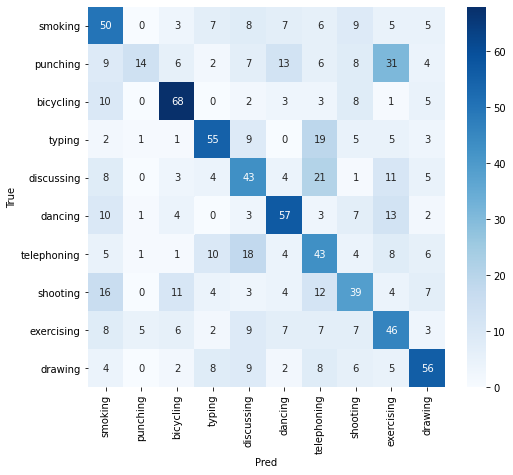

In [41]:
plt.figure(figsize=(8,7))
sns.heatmap(con_matr, annot=True, cmap='Blues')
plt.xlabel('Pred')
plt.ylabel('True');

# Data exploration


In [0]:
train_df = pd.read_csv(root_path+"trainingSet.csv", header=None, 
                 names=['filename', 'label', 'good', 'bad'] )
train_df.head()

,filename,label,good,bad
0,blocking/getty-karate-video-id635808620_4.mp4,blocking,3,0
1,piloting/yt-SWQpGv37JOI_107.mp4,piloting,3,1
2,dining/getty-accross-the-table-video-id5333709...,dining,3,1
3,barbecuing/getty-barbecue-video-id600107508_14...,barbecuing,3,0
4,saluting/getty--video-id106670892_4.mp4,saluting,3,1


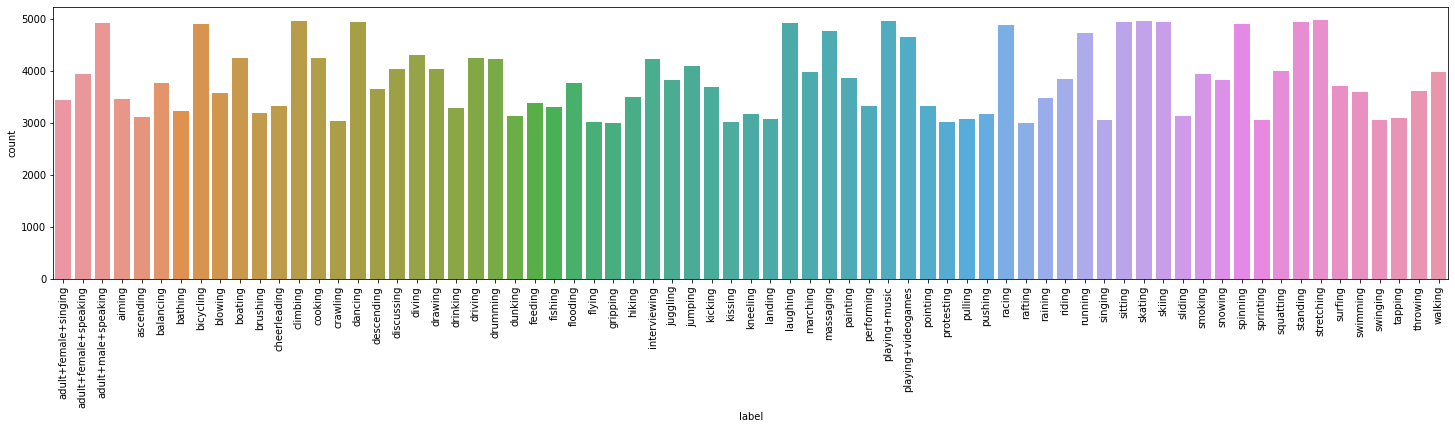

In [0]:
counts = train_df.label.value_counts()
counts = counts[counts>3000].sort_index()
temp_df = train_df[train_df.label.isin(counts.index)]
plt.figure(figsize=(25, 5))
plt.xticks(rotation=90, )
sns.countplot(temp_df.label, order=counts.index.values)